<a href="https://colab.research.google.com/github/marissa-graham/multiagent_systems/blob/master/Lab_3_(Swarms_and_Flocks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
# Math
import numpy as np
from scipy import linalg as la # for norms and spectra

from tqdm import tqdm 

# Plotting
import pylab # for adjusting plot sizes
import seaborn
from matplotlib import pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

from matplotlib import rcParams

# make sure the full paths for ImageMagick and ffmpeg are configured
#rcParams['animation.convert_path'] = r'C:\Program Files\ImageMagick\convert'
#rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'


## Model and experiment setup code

#### AgentModel

In [0]:
class AgentModel:
    """
    Model agents according to system described by Couzin et al.
    
    Model parameters
    ----------------
    locs : 2 x N array with positions of agents
    directions : 2 x N array with initial unit direction vectors of agents
    N : Number of agents
    R_r : Radius of repulsion
    R_o : Radius of orientation
    R_a : Radius of attraction
    alpha : Field of vision (an angle, in degrees)
    theta : Turning rate (also an angle, same units as alpha)
    speed : Units per second
    dt : Time step increment
    
    Additional parameters
    ---------------------
    M : Scale parameter for initial random location placing
    """
    
    def __init__(self, N, R_r, R_o, R_a, alpha, theta, speed, error, 
                 dt=0.1):
        
        self.__dict__.update(locals())
        
    def initialize_random(self, M=1):
        """
        Choose uniformly random initial positions for N agents within a 
        [-M,M] by [-M,M] initial frame.
        """
        self.M = M
        self.locs = 2*M*np.random.rand(2, self.N) - M
        #self.locs = np.random.standard_normal((2, self.N))
        
        # Random unit initial direction vectors
        directions = 2*np.random.rand(2, self.N) - 1
        self.dirs = directions/la.norm(directions, axis=0)
        self.angles = np.angle(self.dirs[0,:] + 1j*self.dirs[1,:], deg=True)
        
    def can_see(self, x_y, v, d):
        """
        Check if point x with direction v can see the point y if x_y is y - x.
        d is the distance between x and y, aka the norm of x_y.
        """
        return 180*np.arccos(np.dot(x_y, v)/d)/np.pi < 0.5*self.alpha
    
    def get_neighbors(self, d, inner_radius, outer_radius, neighbor_type='all'):
        
        candidates = np.logical_and(d>inner_radius, d<=outer_radius)
        candidate_neighbors = np.where(candidates)[0]
        
        if neighbor_type == 'nearest':
            in_bounds = np.where(np.logical_and(d>0, d<=self.R_r))[0]
            n = len(in_bounds)
            nearest_five = in_bounds[np.argsort(d[in_bounds])[:min(5,n)]]
            return nearest_five
        
        #return np.argsort(d[candidates])[:min(5,len(candidate_neighbors))]
        
        elif neighbor_type == 'all':
            candidates = np.logical_and(d>inner_radius, d<=outer_radius)
            candidate_neighbors = np.where(candidates)[0]
            return candidate_neighbors
        
    def get_desired_direction(self, i, neighbor_type):
        
        desired_direction = np.zeros(2)
        
        # Calculate distances between agent and all others
        x_y = self.locs - self.locs[:,i].reshape((2,1))
        d = la.norm(x_y, axis=0)

        if neighbor_type == 'nearest':
            
            in_bounds = np.where(np.logical_and(d>0, d<=self.R_a))[0]
            near5 = in_bounds[np.argsort(d[in_bounds])[:min(5, len(in_bounds))]]
            has_repulsion = False
            has_zoo = 0
            has_zoa = 0
            
            for nbr in near5:
                
                if d[nbr] < self.R_r:
                    has_repulsion = True
                    desired_direction -= x_y[:,nbr]/d[nbr]
                
                if d[nbr] >= self.R_r and d[nbr] < self.R_o:
                    if has_repulsion == False:
                        if self.can_see(x_y[:,nbr], self.dirs[:,i], d[nbr]):
                            has_zoo = 1
                            desired_direction += self.dirs[:,nbr]
                            
                if d[nbr] >= self.R_o and d[nbr] < self.R_a:
                    if has_repulsion == False:
                        if self.can_see(x_y[:,nbr], self.dirs[:,i], d[nbr]):
                            has_zoa = 1
                            desired_direction += x_y[:,nbr]/la.norm(d[nbr])
            
            if has_zoo and has_zoa:
                desired_direction *= 0.5
                
            if la.norm(desired_direction) == 0:
                return self.dirs[:,i]
            else:
                return desired_direction/la.norm(desired_direction)
                    
        # Move away from neighbors in personal space
        too_close = self.get_neighbors(d, 0, self.R_r, 'all')
        for n_r in too_close:
            desired_direction -= x_y[:,n_r]/d[n_r]
        
        # If nobody is in our personal space
        if len(too_close) < 1:
            
            # Align with orientation neighbors
            has_zoo = 0
            for n_o in self.get_neighbors(d, self.R_r, self.R_o, 'all'):
                if self.can_see(x_y[:,n_o], self.dirs[:,i], d[n_o]):
                    has_zoo = 1
                    desired_direction += self.dirs[:,n_o]
            
            # Move towards attraction neighbors   
            has_zoa = 0
            for n_a in self.get_neighbors(d, self.R_o, self.R_a, 'all'):
                if self.can_see(x_y[:,n_a], self.dirs[:,i], d[n_a]):
                    has_zoa = 1
                    desired_direction += x_y[:,n_a]/la.norm(x_y[:,n_a])

            # Account for case where neighbors are in both zones
            if has_zoo and has_zoa:
                desired_direction *= 0.5
         
        if la.norm(desired_direction) == 0:
            return self.dirs[:,i]
        else:
            return desired_direction/la.norm(desired_direction)
                              
    def step(self, neighbor_type="all", n_random=0, n_clueless=0, n_contrarian=0):
        """
        leader_directions is a 2 x num_leaders array if it's not None
        """
        go_towards = np.zeros((2, self.N))
        shuffled = np.random.permutation(self.N)
        
        
        # Random agents pick a random goal direction
        for i in shuffled[:n_random]:
            go_towards[:,i] = 2*self.M*np.random.rand(2) - self.M
        
        # Clueless agents keep going where they already were
        k = n_random
        for i in shuffled[k:k+n_clueless]:
            go_towards[:,i] = self.dirs[:,i]
         
        # Contrarian agents do the opposite of what the model says
        k += n_clueless
        for i in shuffled[k:k+n_contrarian]:
            go_towards[:,i] = -self.get_desired_direction(i, neighbor_type)
        
        # Everybody else follows the model
        k += n_contrarian
        for i in shuffled[k:]:
            go_towards[:,i] = self.get_desired_direction(i, neighbor_type)
        
        # Figure out how far we CAN go in that direction (and add noise)
        desired_angles = np.angle(go_towards[0,:] + 1j*go_towards[1,:], deg=True)
        noise = self.error * np.random.randn(self.N)
        to_add = desired_angles - self.angles + noise
        to_add = (to_add + 180) % 360 - 180 # use shorter path around the circle
        
        # Update to new directions
        self.angles += np.clip(to_add, -self.theta, self.theta)
        self.dirs[0,:] = np.cos(self.angles/180*np.pi)
        self.dirs[1,:] = np.sin(self.angles/180*np.pi)
        
        # Move in those directions
        self.locs += self.speed * self.dt * self.dirs
    
    def get_polarization(self):
        """Calculate polarization (parallel alignment)."""
        return la.norm(np.mean(self.dirs, axis=1))
    
    def get_momentum(self):
        """Calculate angular momentum."""
        
        cgroup = np.mean(self.locs, axis=1)
        ric = self.locs - cgroup.reshape((2,1))
        m_raw = np.cross(ric, self.dirs, axisa=0, axisb=0)
        return la.norm(np.mean(m_raw))
        
    def get_fiedlers(self):
        """
        Connect each agent with all neighbors within attraction radius and then
        calculate the Fiedler eigenvalue.
        """
        
        # All neighbors topology
        A = np.empty((self.N, self.N))
        for i in range(self.N):
            A[i,:] = la.norm(self.locs - self.locs[:,i].reshape((2,1)), axis=0)
        distances = np.copy(A)
        
        A[A > self.R_a] = 0
        A[A > 0] = 1
        L = np.diag(np.sum(A,axis=0)) - A  
        fiedler_all = np.sort(np.real(la.eigvals(L)))[1]
        
        # Nearest five neighbor topology
        A = np.zeros((self.N, self.N))
        
        for i in range(self.N):
            d = la.norm(self.locs - self.locs[:,i].reshape((2,1)), axis=0)
            neighbor_order = np.argsort(d)
            A[i,neighbor_order[:5]] = 1
            
        L = np.diag(np.sum(A,axis=0)) - A  
        fiedler_nearest = np.sort(np.real(la.eigvals(L)))[1]
        
        # Interaction neighbors topology
        A = np.zeros((self.N, self.N))
        for i in range(self.N):
            too_close = self.get_neighbors(distances[i,:], 0, self.R_r)
            if len(too_close) > 1:
                A[i,too_close] = 1
            else:
                A[i,self.get_neighbors(distances[i,:], self.R_r, self.R_a)] = 1
        L = np.diag(np.sum(A,axis=0)) - A  
        fiedler_interaction = np.sort(np.real(la.eigvals(L)))[1]
        
        return fiedler_all, fiedler_nearest, fiedler_interaction

#### run_experiment

In [0]:
def run_experiment(num_agents, M, repulsion_radius, orientation_radius, 
                   attraction_radius, field_of_vision, turning_rate, speed,
                   noise, num_timesteps, num_plots, n_random=0, n_clueless=0,
                   n_contrarian=0, title='auto', neighbor_type='all', 
                   display=True):
    """
    Field of vision and turning rate are both in degrees.
    
    Random agents pick a point at random for their goal.
    Clueless agents ignore all of their neighbors
    Contrarian agents do exactly the opposite of what the model says.
    """
    model = AgentModel(num_agents, repulsion_radius, orientation_radius, 
                       attraction_radius, field_of_vision, turning_rate, 
                       speed, noise)
    model.initialize_random(M=M)
    
    # Plot setup
    num_cols = 4
    num_rows = int(np.ceil(num_plots / num_cols))
    plot_frequency = np.floor(num_timesteps / num_plots)

    fig = plt.figure(figsize=(15, 3.5*(num_rows+1)))
    grid = plt.GridSpec(num_rows + 1, num_cols, wspace=0.32, hspace=0.2)
    print(num_cols, "cols,", num_rows)

    plot_num = 0
    markerstyle = dict(color='blue', size=10)
    msize = 50

    fiedler_ax = fig.add_subplot(grid[:1,:2])
    behavior_ax = fig.add_subplot(grid[:1,2:])
        
    fiedlers = [model.get_fiedlers()]
    pgroups = [model.get_polarization()]
    mgroups = [model.get_momentum()]
    
    # Run the model
    for i in range(num_timesteps):
        
        if display:
            # Intermediate plots
            if i % plot_frequency == 0 and plot_num < num_plots:
                ax = fig.add_subplot(grid[1 + plot_num//4, plot_num%4])
                for j in range(model.N):
                    ax.scatter(model.locs[0,j], model.locs[1,j], s=msize, 
                               marker=(2,0,model.angles[j]-90), c='blue')
                ax.set_title("Stage "+str(i))
                plot_num += 1
            """
            elif num_timesteps - i < 5 and num_timesteps - i > 1:
                ax = fig.add_subplot(grid[-1, i - num_timesteps])
                for j in range(model.N):
                    ax.scatter(model.locs[0,j], model.locs[1,j], s=msize, 
                               marker=(2,0,model.angles[j]-90), c='blue')
                ax.set_title("Stage "+str(i))
            """
        
        # Step the model forward
        model.step(neighbor_type=neighbor_type, n_random=n_random, 
                   n_clueless=n_clueless, n_contrarian=n_contrarian)
        pgroups.append(model.get_polarization())
        mgroups.append(model.get_momentum())
        fiedlers.append(model.get_fiedlers())
        
    # Finish plotting
    domain = np.arange(num_timesteps+1)
    fiedlers = np.array(fiedlers)
    print(np.shape(fiedlers))
    fiedler_ax.plot(fiedlers[:,0], label='all')
    fiedler_ax.plot(fiedlers[:,1], label='nearest')
    fiedler_ax.plot(fiedlers[:,2], label='interaction')
    fiedler_ax.set_ylim(0,np.max(fiedlers))
    fiedler_ax.set_xlabel("Timesteps")
    fiedler_ax.set_title("Fiedler eigenvalue over time")
    fiedler_ax.legend()

    behavior_ax.scatter(domain, pgroups, label="Polarization")
    behavior_ax.scatter(domain, mgroups, label="Angular momentum")
    behavior_ax.set_xlabel("Timesteps")
    behavior_ax.set_title("Collective dynamical behaviours")
    behavior_ax.legend()

    ax = fig.add_subplot(grid[-1,-1])
    for j in range(model.N):
        ax.scatter(model.locs[0,j], model.locs[1,j], s=msize, 
                   marker=(2,0,model.angles[j]-90), c='blue')
    ax.set_title("Stage "+str(i))

    if title == 'auto':
        full_title = str(num_agents)+" agents, (R_r, R_o, R_a)=("
        full_title += str(repulsion_radius)+", "+str(orientation_radius)+", "
        full_title += str(attraction_radius)+"), FOV "+str(field_of_vision)
        full_title += " degrees"
        plt.suptitle(full_title)
    else:
        title += ": N=" + str(num_agents)+", (R_r, R_o, R_a)=("
        title += str(repulsion_radius)+", "+str(orientation_radius)+", "
        title += str(attraction_radius)
        title += "), max m="+str(np.round(np.max(mgroups),2)) + ", avg. m="
        title += str(np.round(np.mean(mgroups),2)) + ", max p="
        title += str(np.round(np.max(pgroups),2)) + ", avg. p="
        plt.suptitle(title+str(np.round(np.mean(pgroups),2))+")")

    plt.show()    
        
    return pgroups, mgroups

## Animate function

In [0]:
def animate_experiment(N, M, R_r, R_o, R_a, FOV, theta, s, noise, num_timesteps,
                      title, neighbor_type='all', n_random=0, n_clueless=0,
                      n_contrarian=0):
    
    model = AgentModel(N, R_r, R_o, R_a, FOV, theta, s, noise)
    model.initialize_random(M=M)

    all_locs = []
    all_angles = []
    mins = []
    maxes = []

    # Run the model
    for i in range(num_timesteps):

        # Step the model forward
        current = np.copy(model.locs)
        all_locs.append(current)
        mins.append(np.min(current))
        maxes.append(np.max(current))
        model.step(neighbor_type=neighbor_type, n_random=n_random, 
                   n_clueless=n_clueless, n_contrarian=n_contrarian)
    x = all_locs[0][0,:]
    y = all_locs[0][1,:]

    gmin = np.min(mins)
    gmax = np.max(maxes)

    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.close()
    ax.set_xlim((gmin, gmax))
    ax.set_ylim((gmin, gmax))

    line1, = ax.plot([], [], 'o')

    def init():
        line1.set_data(x, y)
        return (line1,)

    def animate(i):
        line1.set_data(all_locs[i][0,:], all_locs[i][1,:])
        return (line1,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=num_timesteps, interval=100*100/num_timesteps, blit=False)
    rc('animation', html='html5')

    return anim

## Torus

4 cols, 1
(101, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


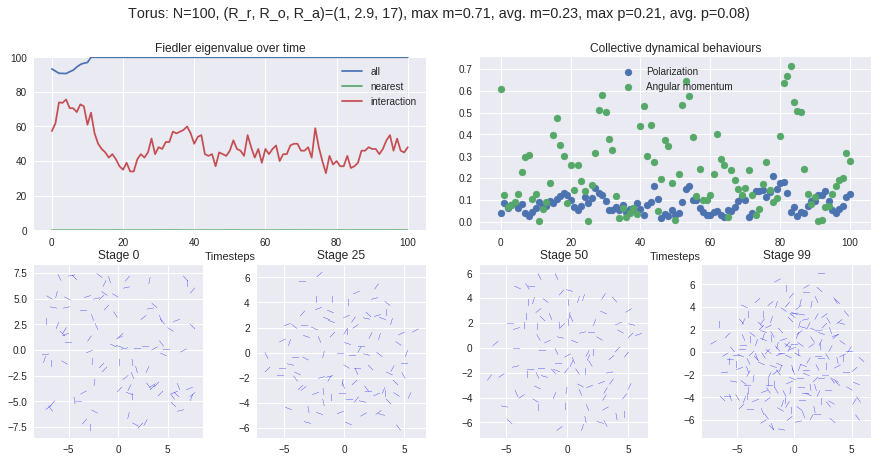

In [0]:
p, m = run_experiment(100, 7.5, 1, 2.9, 17, 270, 40, 3, 0.05, 100, 4, 
                      title="Torus")
anim = animate_experiment(100, 7.5, 1, 2.9, 17, 270, 40, 3, 0.05, 100, 
                          title="Torus attempt")
anim

4 cols, 1
(101, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


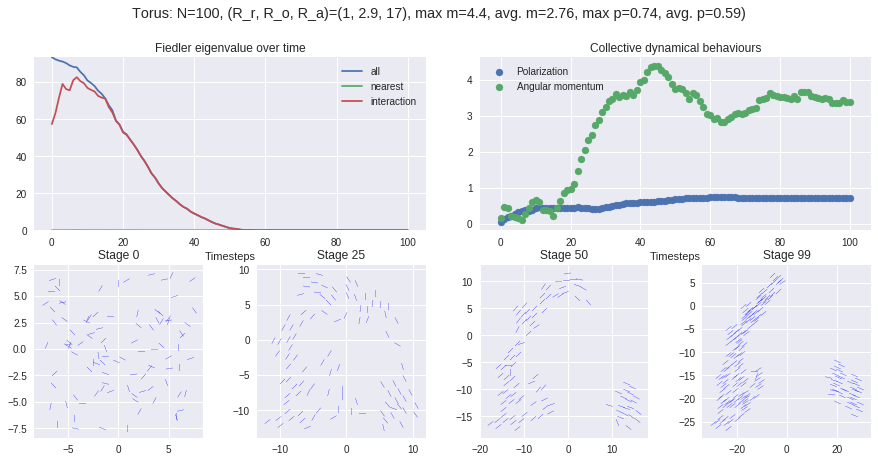

In [0]:
p, m = run_experiment(100, 7.5, 1, 2.9, 17, 270, 40, 3, 0.05, 100, 4, 
                      title="Torus", neighbor_type='nearest')
anim = animate_experiment(100, 7.5, 1, 2.9, 17, 270, 40, 3, 0.05, 100, 
                          title="Torus attempt", neighbor_type='nearest')
anim

## Swarm

4 cols, 1
(102, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


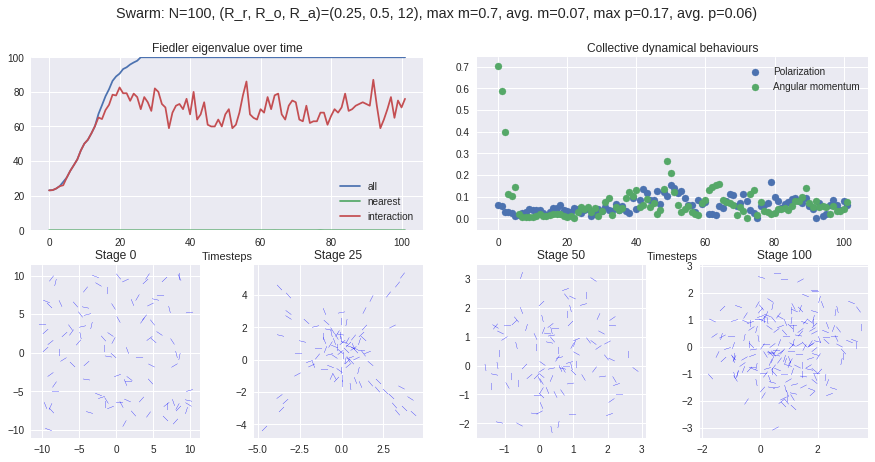

In [0]:
run_experiment(100, 10, 0.25, 0.5, 12, 360, 40, 3, 0.05, 101, 4, title="Swarm")
anim = animate_experiment(100, 10, 0.25, 0.5, 12, 360, 40, 3, 0.05, 101, 
                          "Swarm")
anim

4 cols, 1
(102, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


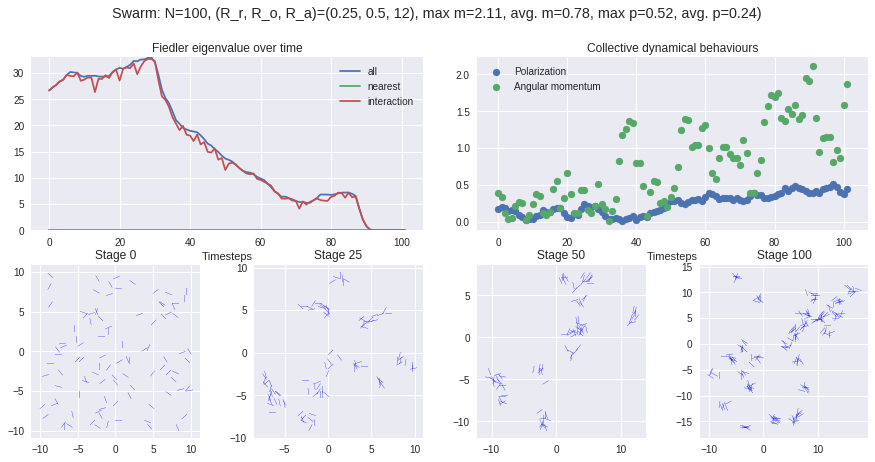

In [0]:
run_experiment(100, 10, 0.25, 0.5, 12, 360, 40, 3, 0.05, 101, 4, title="Swarm",
              neighbor_type='nearest')
anim = animate_experiment(100, 10, 0.25, 0.5, 12, 360, 40, 3, 0.05, 101, 
                          "Swarm", neighbor_type='nearest')
anim

## Dynamic parallel

4 cols, 1
(201, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


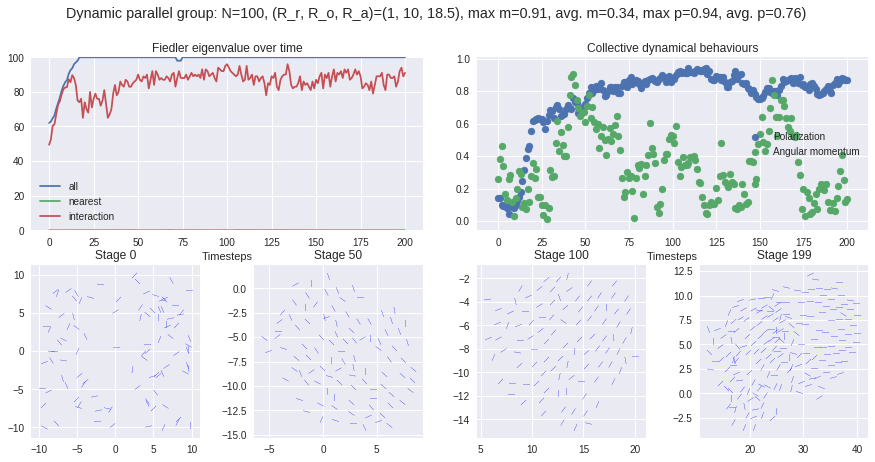

KeyboardInterrupt: ignored

In [0]:
run_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200, 4,
               title="Dynamic parallel group")
anim = animate_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200,
                         title="Dynamic parallel group")
anim

4 cols, 1
(201, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


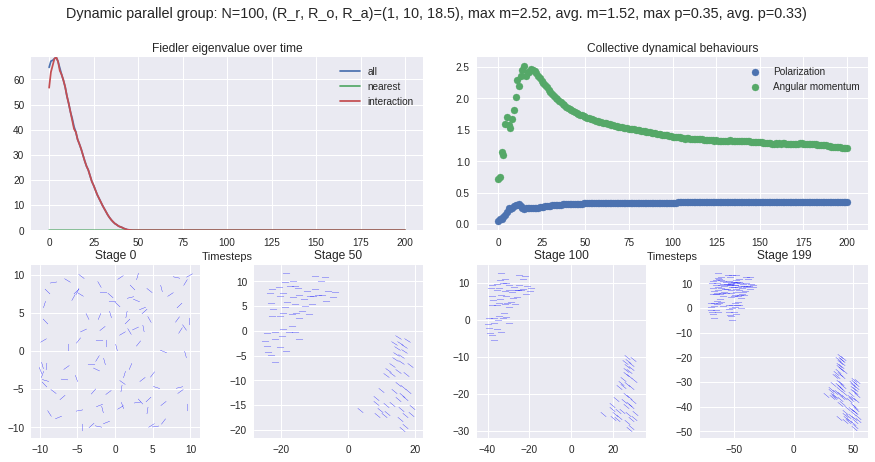

([0.048336192946435694,
  0.07569492445580528,
  0.08700095028468058,
  0.10799734551772823,
  0.1481847808307512,
  0.19405529010980774,
  0.26443002594053966,
  0.24788583354985913,
  0.2532717126795764,
  0.28744445667915824,
  0.29820323098360074,
  0.30870221664109154,
  0.31793977900023984,
  0.2894708837871235,
  0.2627943777161848,
  0.24768823193342973,
  0.2519234100742296,
  0.2583243690053643,
  0.2522073675656311,
  0.2559119352346517,
  0.25201906654294876,
  0.2520853198476665,
  0.25787355587165395,
  0.26281265669398524,
  0.26824987338957657,
  0.27332548206891755,
  0.27824933870522384,
  0.282781540242515,
  0.28688072161300693,
  0.29082764773001724,
  0.29454788336849513,
  0.2980647316327781,
  0.30119556183265245,
  0.3041369877967082,
  0.3066602962532736,
  0.30902237387432746,
  0.31123900187423165,
  0.313235745266954,
  0.3151879685953141,
  0.31697405388833944,
  0.3185659876375022,
  0.32002537254394303,
  0.32149545965486714,
  0.32261115875250373,
  0.3

In [0]:
run_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200, 4,
               title="Dynamic parallel group", neighbor_type='nearest')
#anim = animate_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200,
#                         title="Dynamic parallel group", neighbor_type='nearest')
#anim

## Highly parallel

4 cols, 1
(101, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


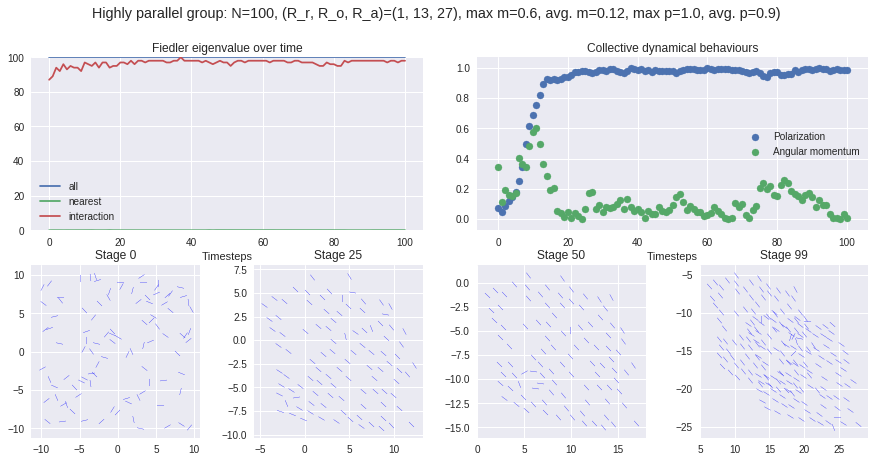

In [0]:
run_experiment(100, 10, 1, 1 + 12, 1 + 12 + 14, 270, 40, 3, 0.05, 100, 4, 
               title="Highly parallel group")
anim = animate_experiment(100, 10, 1, 13, 26, 270, 40, 3, 0.05, 100, 
                          "Highly parallel group")
anim

4 cols, 1
(101, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


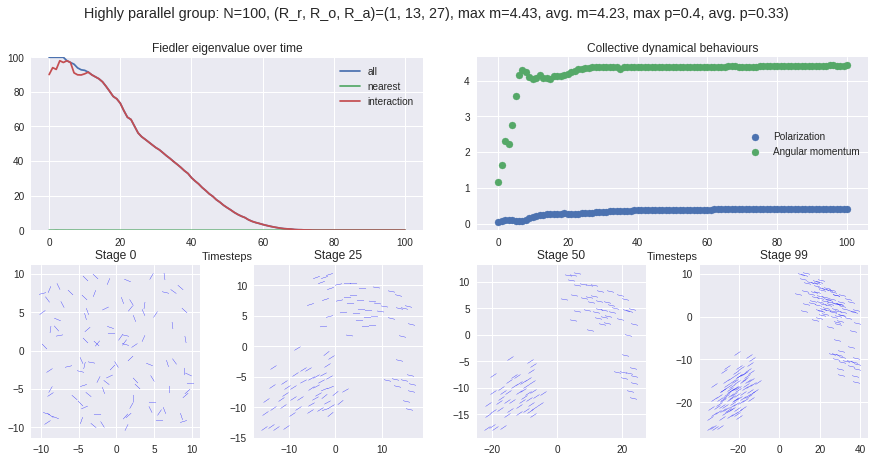

In [0]:
run_experiment(100, 10, 1, 1 + 12, 1 + 12 + 14, 270, 40, 3, 0.05, 100, 4, 
               title="Highly parallel group", neighbor_type='nearest')
anim = animate_experiment(100, 10, 1, 13, 26, 270, 40, 3, 0.05, 100, 
                          "Highly parallel group", neighbor_type='nearest')
anim

## Modified

4 cols, 2
(201, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


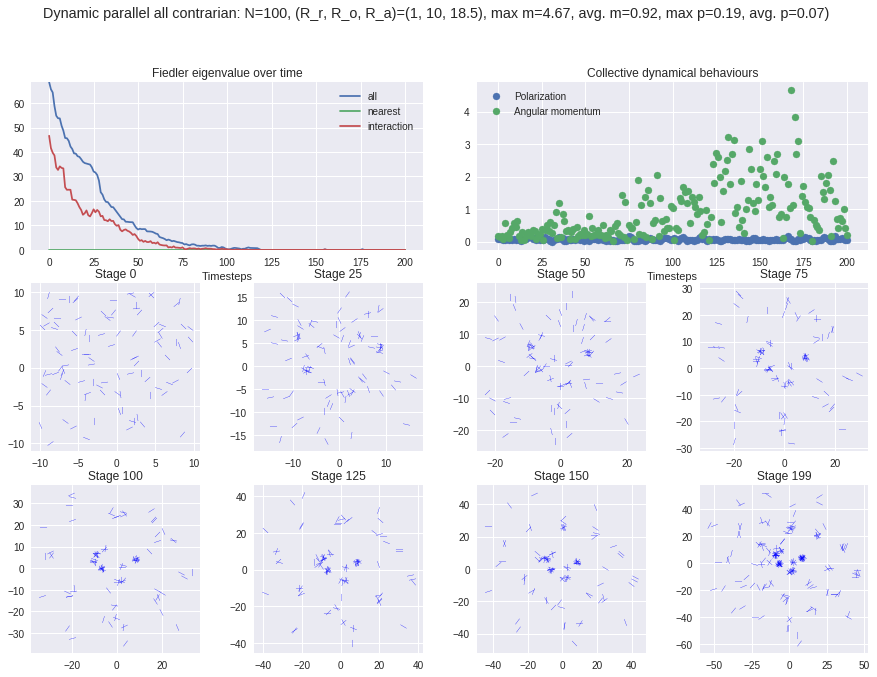

In [0]:
run_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200, 8,
               title="Dynamic parallel all contrarian", n_contrarian=100)
anim = animate_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200,
                         title="Dynamic parallel all contrarian", n_contrarian=100)
anim

4 cols, 2
(201, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


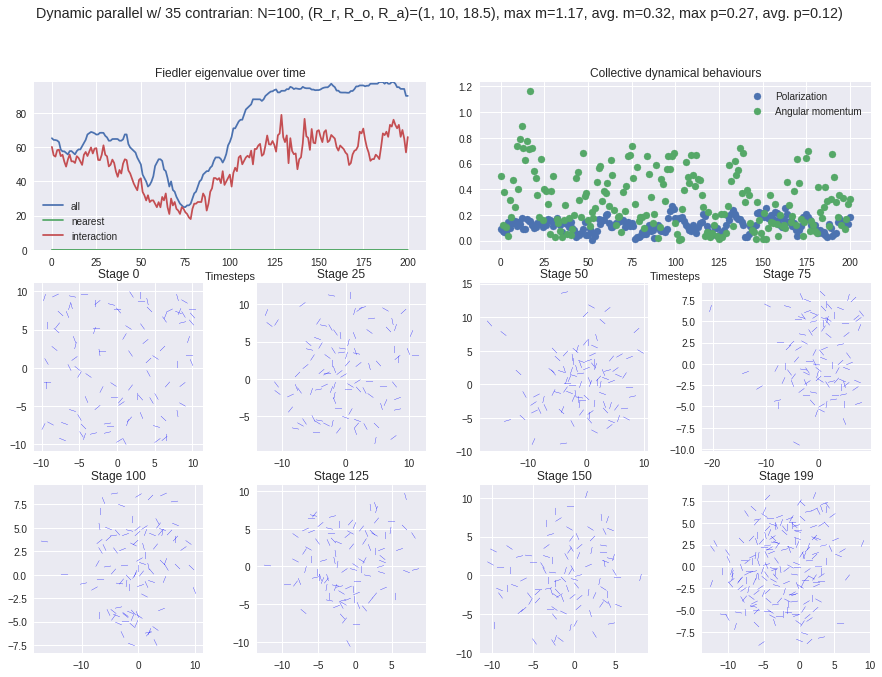

In [0]:
run_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200, 8,
               title="Dynamic parallel w/ 35 contrarian", n_contrarian=35)
anim = animate_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200,
                         title="Dynamic parallel group w/ 35 contrarian", n_contrarian=35)
anim

4 cols, 2
(201, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


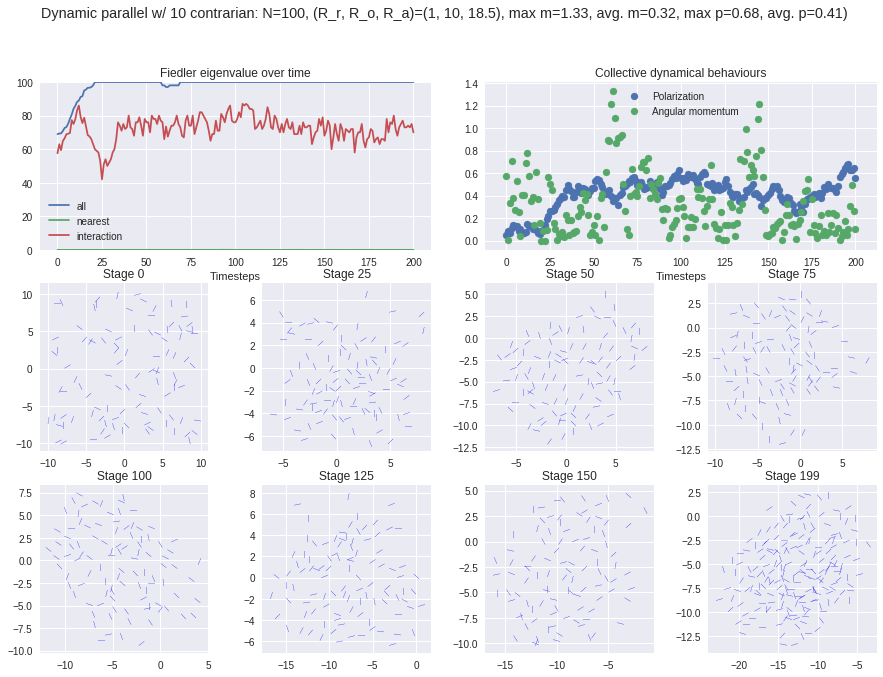

In [0]:
run_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200, 8,
               title="Dynamic parallel w/ 10 contrarian", n_contrarian=10)
anim = animate_experiment(100, 10, 1, 10, 18.5, 270, 40, 3, 0.05, 200,
                         title="Dynamic parallel group w/ 10 contrarian (kind of a dynamic torus)", n_contrarian=10)
anim

In [0]:
#run_experiment(100, 10, 1, 1 + 12, 1 + 12 + 14, 270, 40, 3, 0.05, 100, 4, 
#               title="Highly parallel w/ 70 clueless", n_clueless=70)
anim = animate_experiment(100, 10, 1, 13, 26, 270, 40, 3, 0.05, 100, 
  "Highly parallel w/ 80 clueless (roughly dynamic parallel)", n_clueless=80)
anim

4 cols, 1
(101, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


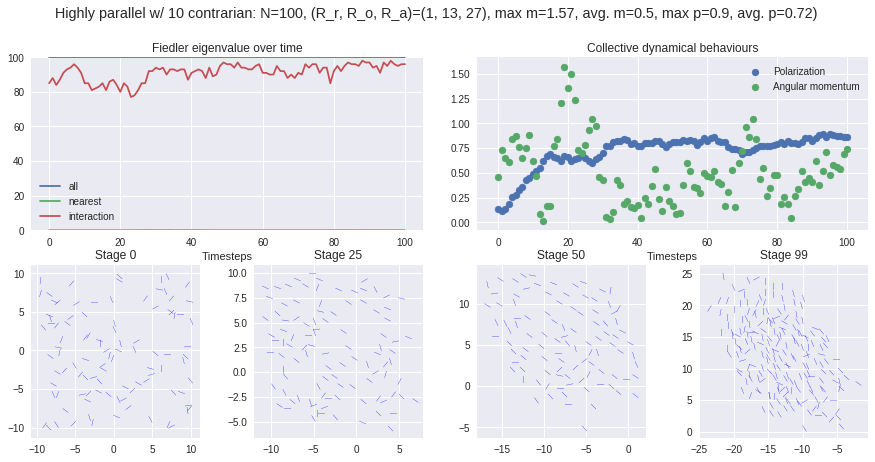

In [0]:
#run_experiment(100, 10, 1, 1 + 12, 1 + 12 + 14, 270, 40, 3, 0.05, 100, 4, 
#               title="Highly parallel w/ 10 contrarian", n_contrarian=10)
anim = animate_experiment(100, 10, 1, 13, 26, 270, 40, 3, 0.05, 100, 
                          "Highly parallel w/ 10 contrarian (slow dynamic parallel)", n_contrarian=10)
anim

In [0]:
anim = animate_experiment(100, 10, 0.25, 0.5, 25, 360, 40, 3, 0.05, 201, 
                          "Swarm w/ no contrarian", n_contrarian=0)
anim

In [0]:
anim = animate_experiment(100, 10, 0.25, 0.5, 25, 360, 40, 3, 0.05, 201, 
                          "Swarm w/ 85 contrarian", n_contrarian=10)
anim

In [0]:
anim = animate_experiment(100, 10, 0.25, 0.5, 100, 360, 40, 3, 0.05, 501, 
                          "Swarm w/ 95 clueless", n_clueless=95)
anim

4 cols, 1
(202, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


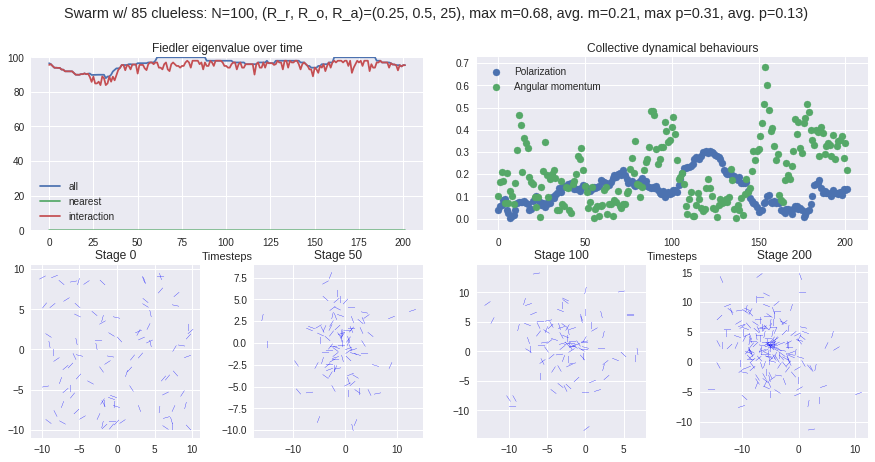

In [0]:
run_experiment(100, 10, 0.25, 0.5, 25, 360, 40, 3, 0.05, 201, 4, 
               title="Swarm w/ 85 clueless", n_clueless=85)
anim = animate_experiment(100, 10, 0.25, 0.5, 25, 360, 40, 3, 0.05, 201, 
                          "Swarm w/ 85 clueless", n_clueless=85)
anim